# Conversion Rate Project
Analysis conversion rates dataset for business decision need. This project is in jedha certfication #block3

### Purpose : 
> rate conversion of user subscription; \
> minimal feature importance; \
> f1-score.

### Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score !

In [60]:
# import
import os
import json
import joblib
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from module import helper
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# plotly
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

In [62]:
# sns 
color_palette = ['#265952', '#DFCEEB', '#DBDE2F', '#45201E', '#c7ac92', '#a44a3f']
sns.set_palette(sns.color_palette(color_palette))

## Load data

In [63]:
# load dataset
conversion_csv = "../data/raw/conversion_data_train.csv"
conversion_df_raw = pd.read_csv(conversion_csv)
conversion_df = conversion_df_raw.copy()

print('Set with labels (our train+test) :', conversion_df.shape)

Set with labels (our train+test) : (284580, 6)


## EDA

#### General statistics

In [64]:
# helper functions : general_statistics()
def general_statistics(df) :
    """ general eda.
    """

    # Basic stats
    print("Number of rows : {}".format(df.shape[0]))
    print()

    print("Display of dataset: ")
    display(df.head())
    print()

    print("Basics statistics: ")
    data_desc = df.describe(include='all')
    display(data_desc)
    print()

    print("General information: ")
    display(df.info())
    print()

    print("Percentage of missing values: ")
    display(100*df.isnull().sum()/df.shape[0])

## stats on conversion_df
helper.general_statistics(conversion_df)

Number of rows : 284580

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



General information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


None


Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

#### Visualizations

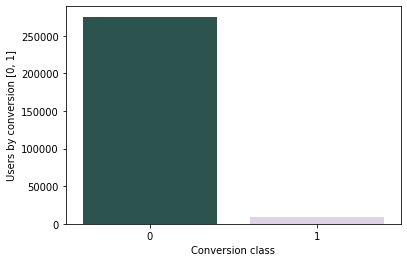

In [65]:
# converted (new_user or not)
converted_df = pd.DataFrame(conversion_df.groupby(["converted"]).size()).reset_index()
converted_df = converted_df.rename(columns={0: "Users by conversion [0, 1]", 
                                            "converted" : "Conversion class"})     

# bar plot by conversion class
ax = sns.barplot(x="Conversion class", y="Users by conversion [0, 1]", data=converted_df)

In [66]:
# converted by country
converted_country_df = conversion_df.groupby(["country", "converted"]) \
                                    .size()

display(converted_country_df)


country  converted
China    0             69033
         1                89
Germany  0             10963
         1               730
UK       0             41350
         1              2291
US       0            154054
         1              6070
dtype: int64

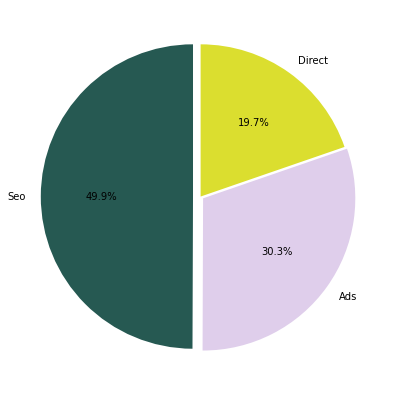

In [67]:
# converted by source
# group by source on only converted dataset
mask_converted = conversion_df["converted"] == 1
converted_source_df = pd.DataFrame(conversion_df[mask_converted].groupby(["source"]).size()).reset_index()

# rename columns
converted_source_df = converted_source_df.rename(columns={0: "Users converted by source"})  

# change values to percentage
converted_source_df["Users converted by source"] = (converted_source_df["Users converted by source"] / converted_source_df["Users converted by source"].sum()) * 100

# sort values in descending
converted_source_df = converted_source_df.sort_values(["Users converted by source"], ascending=False)

# pie chart
converted_by_source = converted_source_df["Users converted by source"].values
names = list(converted_source_df["source"].unique())
explode = (0.05,0.02,0)

fig, ax = plt.subplots(figsize=(7,7))
_ = ax.pie(converted_by_source, labels=names, 
       autopct="%1.1f%%", 
       explode=explode, 
       shadow=False,
       startangle=90) #colors=color_palette[:4],


## Feature engineering
> choose variables, \
> split dataset, \
> preprocessing pipeline.

#### Pandas preprocessing

In [68]:
# missing values
print("Percentage of missing values in dataset: ")
display(100*conversion_df.isnull().sum()/conversion_df.shape[0])
print("No missing values in dataset")

Percentage of missing values in dataset: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

No missing values in dataset


In [69]:
# columns
display(conversion_df.columns)

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [70]:
# choose features & target
features_vars = ["age", "new_user", "total_pages_visited"]
target_var = "converted"

In [71]:
# separate target variable from others
Y_df = conversion_df.loc[:,target_var]
X_df = conversion_df.loc[:,features_vars]

print("Separating labels from features...")
print("Target")
print(Y_df.head())

print("\nFeatures")
print(X_df.head())
print()

Separating labels from features...
Target
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

Features
   age  new_user  total_pages_visited
0   22         1                    2
1   21         1                    3
2   20         0                   14
3   23         1                    3
4   28         1                    3



In [72]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X = X_df.values
Y = Y_df.tolist()
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[22  1  2]
 [21  1  3]
 [20  0 14]
 [23  1  3]
 [28  1  3]]

[0, 0, 1, 0, 0]


#### Sklearn preprocessing

In [73]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [74]:
# feature cat & num variables
# cat & num variables
cat_vars = ["new_user"]
num_vars = ["age", "total_pages_visited"]

In [75]:
X_df.head(1)

,age,new_user,total_pages_visited
0,22,1,2


In [76]:
# pipeline categorical & numerical
# helper function : var_index
# def var_index(df, name) :
#     return df.columns.to_list().index(name)

# pipeline for numeric features
numeric_features = [helper.var_index(X_df, name) for name in num_vars]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])


# Create pipeline for categorical features
categorical_features = [helper.var_index(X_df, name) for name in cat_vars]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


display(numeric_features)
display(categorical_features)

[0, 2]

[1]

In [77]:
# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [78]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[23  0  4]
 [25  1  8]
 [32  1  2]
 [37  1  3]
 [24  1  4]]
...Done.
[[-0.91516278 -0.26070136  0.        ]
 [-0.67320988  0.93728655  1.        ]
 [ 0.17362526 -0.85969532  1.        ]
 [ 0.7785075  -0.56019834  1.        ]
 [-0.79418633 -0.26070136  1.        ]]

Performing preprocessings on test set...
[[20  1  7]
 [31  1  5]
 [28  0  4]
 [25  1  4]
 [44  0  7]]
...Done.
[[-1.27809213  0.63778957  1.        ]
 [ 0.05264881  0.03879562  1.        ]
 [-0.31028053 -0.26070136  0.        ]
 [-0.67320988 -0.26070136  1.        ]
 [ 1.62534265  0.63778957  0.        ]]



## Modelling
> Model 1 : Logistic regression \
> Model 2 : Random forest.

#### Model 1 : LogisticRegression()

In [79]:
# train model
print("train_model()")
model_name = "LogisticRegression"
model_abs_name = helper.train_model(model_name, X_train, Y_train, log=True)
print()

# load model
print("load_model()")
classifier = joblib.load(model_abs_name)
display(classifier)
print()

# Predictions
print("prediction()")
Y_train_pred = helper.prediction(classifier, X_train, step="Training")
Y_test_pred = helper.prediction(classifier, X_test, step="Test")
print()

# Performance
print("performance()")
f1_train = f1_score(Y_train, Y_train_pred)
f1_test = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_train)
print("f1-score on test set : ", f1_test)
print()

# Confusion
print("confusion_matrix()")
confusion_m_train = helper.c_matrix(Y_train, Y_train_pred, log=True, step="train")
confusion_m_test = helper.c_matrix(Y_test, Y_test_pred, log=True, step="test")
print()

train_model()
trained LogisticRegression model !

load_model()


LogisticRegression()


prediction()
predictions on Training set...
[0 0 0 ... 0 0 0]

predictions on Test set...
[0 0 0 ... 0 0 0]


performance()
f1-score on train set :  0.742210404308993
f1-score on test set :  0.7436652916912198

confusion_matrix()
confusion matrix on train set : 
[[246898   1001]
 [  2780   5443]]
confusion matrix on test set : 
[[27392   109]
 [  326   631]]



### Model 2 : RandomForest()

In [80]:
# train model
print("train_model()")
train_bool = False

model_name = "RandomForest-GridS"
if train_bool : 
    params = {
                    'max_depth': [2, 4, 6, 8, 10],
                    'min_samples_leaf': [1, 2, 5],
                    'min_samples_split': [2, 4, 8],
                    'n_estimators': [10, 20, 40, 60, 80, 100]
                }  
    # params = {
    #                 'max_depth': [2],
    #                 'min_samples_leaf': [1],
    #                 'min_samples_split': [2, 4],
    #                 'n_estimators': [20, 40]
    #             } 
    model_abs_name = helper.train_model(model_name, X_train, Y_train, log=True, params=params)
    print()

else : 
    model_abs_name = f'../data/temp/{model_name}.joblib.pkl'

# load model
print("load_model()")
classifier = joblib.load(model_abs_name)
display(classifier)
print()

# Predictions
print("prediction()")
Y_train_pred = helper.prediction(classifier, X_train, step="Training")
Y_test_pred = helper.prediction(classifier, X_test, step="Test")
print()

# Performance
print("performance()")
f1_train = f1_score(Y_train, Y_train_pred)
f1_test = f1_score(Y_test, Y_test_pred)
print("f1-score on train set : ", f1_train)
print("f1-score on test set : ", f1_test)
print()

# Confusion
print("confusion_matrix()")
confusion_m_train = helper.c_matrix(Y_train, Y_train_pred, log=True, step="train")
confusion_m_test = helper.c_matrix(Y_test, Y_test_pred, log=True, step="test")
print()

train_model()
load_model()


RandomForestClassifier(max_depth=6, min_samples_leaf=5, n_estimators=20)


prediction()
predictions on Training set...
[0 0 0 ... 0 0 0]

predictions on Test set...
[0 0 0 ... 0 0 0]


performance()
f1-score on train set :  0.7446462455950122
f1-score on test set :  0.7436950146627564

confusion_matrix()
confusion matrix on train set : 
[[246860   1039]
 [  2729   5494]]
confusion matrix on test set : 
[[27387   114]
 [  323   634]]



## Competition (best model)
Use our best model, train on all training competition dataset and test on competitor (TA) tetst data.

In [82]:
# best model
best_model_file = "../data/temp/RandomForest-GridS.joblib.pkl"
best_model_file = "../data/temp/LogisticRegression.joblib.pkl"
classifier = joblib.load(best_model_file)

In [83]:
# Concatenate our train and
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

display(X.shape)

(284580, 3)

In [84]:
# train model
classifier.fit(X,Y)

LogisticRegression()

In [85]:
# Q1 test dataset
data_without_labels = pd.read_csv('../data/raw/conversion_data_test.csv')
print('Kaggle test dataset :', data_without_labels.shape)

Kaggle test dataset : (31620, 5)


In [86]:
# Feature engineering
# fetch features
features_vars = ["age", "new_user", "total_pages_visited"]
X_without_labels_df = data_without_labels.loc[:, features_vars]

# convert to array (DataFrame)
X_without_labels = X_without_labels_df.values

# preprocessing
X_without_labels = preprocessor.transform(X_without_labels) 

In [87]:
# prediction
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('../data/shared/conversion_data_test_predictions_mkrouma.csv', index=False)

In [88]:
Y_predictions["converted"].unique()

array([1, 0])